## SNO+ Scattering Pseudo-MC
A simple test using known results to determine the viability of nuclear recoil
explaining the odd behaviour at 2.2 MeV.

In [186]:
# importing the usual suspects
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from multiprocessing import Pool, cpu_count, Manager
from math import floor

# for faster bin insertion
import bisect

# random number generation
import random
# i just picked an arbitrary seed here
# if it matters it's easy to change
random.seed("snoplus")

plt.rcParams['figure.figsize'] = (12, 8)

In [187]:
# now we read in the stopping power data from ASTAR
stoppingpowers = pd.read_csv(Path("stoppingpowers/lab.csv"))
# rename cols to make them easier to reference
stoppingpowers.columns = ["KE", "electron", "nuclear", "total"]
# reindex the dataframe by kinetic energy to make lookups easier
#stoppingpowers.set_index("KE", inplace=True)
print(stoppingpowers)

         KE  electron   nuclear   total
0    0.0180     0.691  0.068500  653.60
1    0.0200     0.730  0.063800  682.84
2    0.0225     0.774  0.058900  716.38
3    0.0250     0.816  0.054800  749.06
4    0.0275     0.856  0.051300  780.02
..      ...       ...       ...     ...
75  15.0000     0.430  0.000275  369.80
76  16.0000     0.408  0.000260  350.88
77  17.0000     0.389  0.000246  334.54
78  18.0000     0.371  0.000234  319.06
79  20.0000     0.341  0.000213  293.26

[80 rows x 4 columns]


So now we have the stopping power data available to us and formatted nicely.

**NB**: the initial revision here is without scattering to get a grip on things

The setup is that we have some sort of particle with a given energy E_0 (i'm not sure exactly what yet -
need to figure that out)
The general process goes like this:
- Look up stopping power in the table for the energy of our event
- Find dE (**NOTE**: need to figure out what dx will be here first - see
  wikipedia page for stopping power)
- Add dE to the bin for an event of that energy
- Repeat this, as if we had an energy of E_j = E_0 - dE
- Terminate once E_j is less than some given epsilon (generally close to zero -
  but we will never reach zero exactly)

Implementation notes: Can use recursion, but that is setting myself up for a
nightmare so let's keep things iterative

Also - how to deal with events which aren't exactly a given KE in the table.
Data is nonlinear but describes the derivative of energy w.r.t. position - the
function "looks like" it is C-infinity (ie. continuous derivatives) and differentiability
implies linearity in a neighbourhood so a linear interpolation should be a very
accurate estimation 

In [188]:
# Let's set up the bins for events here
# I don't know of any prepackaged solution for this so let's write a structure
# to hold binned data for us

# this kind of seems unnecessary to me, but also I would be implementing the
# exact same logic in a messier form otherwise so I digress
class CountBin:
    def __init__(self, low, high):
        self._low = low
        self._high = high
        self._count = 0
    
    # setting properties for the bin count
    @property
    def count(self):
        return self._count

    @count.setter
    def count(self, new_count):
        self._count = new_count

    # increment and decrement convenience functions
    def increment(self):
        self.count = self._count + 1       

    def decrement(self):
        self.count = self._count - 1

    # properties for bin bounds
    @property
    def low_range(self):
        return self._low

    @property
    def high_range(self):
        return self._high

    def __str__(self):
        return f"CountBin(low={self.low_range}, high={self.high_range}, count={self.count})"
    

class BinnedCountData:
    def __init__(self, num_bins, d=None, startpoint=0, endpoint=1):
        if d != None:
            low = min(d)
            high = max(d)
        else:
            low = startpoint
            high = endpoint

        self.binEdges = np.linspace(low, high, num_bins+1)

        self.bins = []

        i = 0
        while i < len(self.binEdges)-1:
            self.bins.append(CountBin(self.binEdges[i], self.binEdges[i+1]))
            i += 1


    def get_bin_index(self, v):
        #i = 0
        #while i < len(self.binEdges) - 1:
        #    if v <= self.binEdges[i+1]:
        #        return i
        #    i += 1
        return (bisect.bisect_left(self.bin_edges, v) - 1)

    @property
    def bin_min(self):
        return min(self.binEdges)
    
    @property
    def bin_max(self):
        return max(self.binEdges)

    @property
    def bin_edges(self):
        return self.binEdges

    @property
    def num_bins(self):
        return len(self.bins)

    # add a value to the correct count bin
    def add_count_by_value(self, v):
        # TODO is there a faster algorithm for this?
        self.bins[self.get_bin_index(v)].increment()

    # count an entire list
    def add_count_by_list(self, l):
        for i in l:
            self.add_count_by_value(i)

    def set_count_by_index(self, idx, c):
        self.bins[idx].count = c

    @property
    def counts(self):
        return [i.count for i in self.bins]

    def get_count_by_value(self, v):
        # get count of a bin some value is in
        return self.bins[self.get_bin_index(v)].count

In [189]:
# and a helper function to merge histograms
def merge_hists(hists: list[BinnedCountData]):
    low = hists[0].bin_min
    high = hists[0].bin_max
    n_bins = hists[0].num_bins
    new_hist = BinnedCountData(n_bins, startpoint=low, endpoint=high)

    i = 0
    while i < n_bins:
        new_hist.set_count_by_index(i, sum([k.counts[i] for k in hists]))
        i += 1

    return new_hist

Now we do the linear interpolation of the ASTAR data
Although the data is nonlinear, this is still decently accurate since it is a differentiable function 

In [190]:
# now to do the linear interpolation for the ASTAR dataset
def stp_interp(e, stp=stoppingpowers):
    # NOTE this assumes that the stopping powers are sorted
    # we get them this way from ASTAR so it's not an issue, but we can fix that if need be
    for k in stp.index:
        if e >= stp["KE"].max():
            return (stp["total"].iloc(-1))/(stp["KE"].iloc(-1))*e
        elif e <= stp["KE"][k+1] and e >= stp["KE"][k]:
            ke_low = stp["KE"][k]
            sp_low = stp["total"][k]
            ke_high = stp["KE"][k+1]
            sp_high = stp["total"][k+1]
            break

    return ((sp_high - sp_low)/(ke_high - ke_low)) * e + sp_low


Here we define a function to compute the scattering probability for each event

*NB:* See http://hyperphysics.phy-astr.gsu.edu/hbase/Nuclear/crosec2.html#c1

In [191]:
def scattering_probability(ke, dx):
    sample_dim = 1 # cm

    N_A = 6.02214E23 # mol^-1
    mol_wt = 246.43 # for LAB, need to verify
    rho = 0.8562 # g/cm^3, see above
    #n = ((N_A/mol_wt) * rho)*(sample_dim**2)*dx
    n = N_A/(mol_wt) * dx * rho
    Z = 1 

    D = ((197.3/137) * (2*Z)/ke)*1E-15
    # the 140.646 comes from integrating the differential cx expression in
    # 02_rutherford
    # here we only account for scattering > 10 degrees (around 0.1745 rad)
    sigma = 4E6*4*np.pi*np.power(D, 2)
    #print(sigma*10E24)
    #sigma = 524.582*4*np.pi*np.power(D, 2)
    # total particle effective area
    eff_a = sigma*n

    # the total area
    total_a = sample_dim**2
    return eff_a/total_a


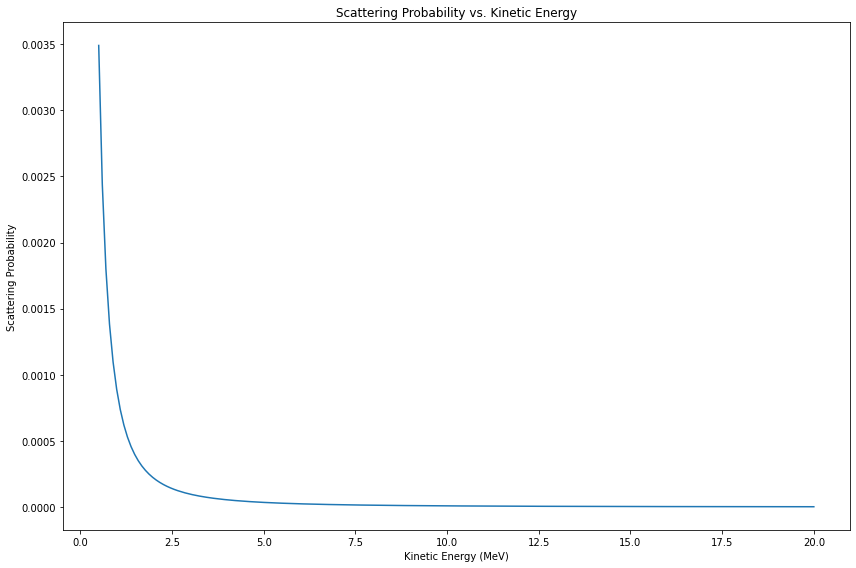

In [192]:
dx_pr = 0.001
ke_xrange = np.linspace(0.5, 20, 200)
plt.plot(ke_xrange, [scattering_probability(i, dx_pr) for i in ke_xrange])
plt.xlabel("Kinetic Energy (MeV)")
plt.ylabel("Scattering Probability")
plt.title("Scattering Probability vs. Kinetic Energy")
plt.tight_layout()
plt.show()

And now let's write a function to sample from the differential cross-section as a distribution

In [193]:
def diff_cx(theta, ke):
    Z = 1 
    D = ((198.3/137) * (2*Z)/ke)*1E-15
    #return np.pi/4 * D**2 * (np.cos(theta/2)/np.power(np.sin(theta/2),3))
    return np.pi/8 * D**2 * (1/np.power(np.sin(theta/2), 4))

def scaled_diff_cx(theta, ke):
    # luckily, our differential crossection is a decreasing function on the interval we care about
    # so, we just take the left endpoint as our x-value
    theta_min = 0.001
    scale = 1/(diff_cx(theta_min, ke))
    return diff_cx(theta,ke)*scale

def scattering_angle(ke):
    theta_min = 0.001
    Z = 48
    while True:
        # first we sample from a uniform distribution of valid x-values
        xsample = random.uniform(theta_min, np.pi/2)
        # then find the scaled differential crosssection at the x-sample
        scx = scaled_diff_cx(xsample, ke)
        # and then return the x-sample if a random number is less than that value
        if random.random() < scx:
            return xsample

Now let's sort out the transferred energy. In my notes I have the long
derivation for 2-d elastic collisions but that can be found in any classical
mechanics textbook.

Note that the initial velocity of the alpha particle is given since the initial
energy is known, and the scattering angle is sampled from the distribution given
by the differential crosssection.

Let
$$ \kappa = \frac{m_{\alpha}}{m_{p}} $$

Then, we have
$$
    v_{\alpha}^{\prime} = v_{\alpha}\frac{( \sqrt{1 - \kappa^2\sin^2{\theta_1}} )}{1 + \kappa}
$$

where $\theta_1$ is the scattering angle of the alpha, $\theta_2$ the angle of
the proton, primed velocities are final and unprimed are initial.

Now, using this and the intial equations we can find a relation describing
$theta_2$. We have

$$
    \tan{\theta_2} = \frac{v_{\alpha}^{\prime}\sin{\theta_1}}{v_{\alpha} - v_{\alpha}^{\prime}\cos{\theta_1}}
$$

Finally, using these two we may find the final proton velocity

$$
v_{p}^{\prime} = \kappa v_{\alpha}\frac{\sin{\theta_1}}{\sin{\theta_2}}
$$

Yielding the final velocities of each particle.
After this, it's just a matter of substituting that velocity into the kinetic
energy expression using the appropriate mass.

In [194]:
def energy_transfer(e_i, scatter_angle=None):
    # TODO need to handle the case where alpha does not deflect (or has a very
    # small deflection angle?)
    # returns a tuple with the new alpha-energy and proton-energy in coordinate
    # 0 and 1 respectively
    # as well as the scattering angle (if we need it later) in pos. 2
    m_alpha = 6.646E-27 # kg
    m_proton = 1.6726E-27 # kg

    if scatter_angle is None:
        scatter_angle = scattering_angle(e_i)
    # just identifying scatter_angle as theta_1 to match the algebra
    theta_1 = scatter_angle

    kappa = m_alpha/m_proton

    # need to convert mev to joules 
    mev_to_j = 1.602176e-13
    ei_j = e_i * mev_to_j
    valpha_i = np.sqrt((2*ei_j)/m_alpha)

    # TODO compute both + and - solns, take whichever satisfies conservation of energy
    # breaking this up into two parts
    try:
        gamma = (1/(1+kappa))*np.sqrt((kappa**2)*(valpha_i**2)*(np.cos(theta_1)**2) - (kappa**2 - 1)*(valpha_i**2))
    except:
        print(theta_1)
        return (0, 0, 0)
    #valpha_f = (1/(1+kappa))*(valpha_i*kappa*np.cos(theta_1)) + gamma
    valpha_f = (1/(1+kappa))*(kappa*valpha_i*np.cos(theta_1)) + gamma

    theta_2 = np.arctan((valpha_f*np.sin(theta_1))/(valpha_i - valpha_f*np.cos(theta_1)))
    
    vproton_f = (kappa*valpha_f*np.sin(theta_1))/(np.sin(theta_2))

    # and now convert back to mev
    ea_f = 0.5*m_alpha*(valpha_f**2)*(1/mev_to_j)
    ep_f = 0.5*m_proton*(vproton_f**2)*(1/mev_to_j)

    return (ea_f, ep_f, theta_1)




Now, let's write the function that does the simulation

In [195]:
def scatter_sim(e_0: float, epsilon=0.1, density=0.8562, stepsize=0.001) -> tuple[list, list]:
    # TODO add ability to get scattering angles out
    # we can do the binning/etc later
    # I hope this doesn't make it take a bunch of memory though
    res = []
    p_res = []
    e_i = e_0
    while e_i > epsilon:
        if scattering_probability(e_i, stepsize) > random.random():
            # here, we need to figure out the change in momentum and energy due to the scattering
            # both the proton and alpha particle will cause an event, so we need
            # to tally both
            transfer_e = energy_transfer(e_i)
            e_i = transfer_e[0] 
            p_e = transfer_e[1]
            #p_res = scatter_sim(transfer_e[1], epsilon=epsilon,
            #density=density, stepsize=stepsize)
            # nesting these here since we probably want to not compute things
            # for proton-proton collisions
            while p_e > epsilon:
                p_res.append(p_e)
                p_e = p_e - stp_interp(p_e)*stepsize
        else:
            #data.add_count_by_value(e_i)
            res.append(e_i)
            # we don't need to multiply by the density here since the LAB data
            # has that baked in for us
            e_i = e_i - stp_interp(e_i)*stepsize
    return (res, p_res)

Let's compute some potential energy transfer values to the proton, before we run
a long and computationally heavy simulation

In [196]:
ei_range = np.linspace(1, 14, 1000)
#ei_range = 14*np.ones(500)
with Pool(int(0.75*cpu_count())) as p:
    transfer_e_raw = p.map(energy_transfer, ei_range)
transfer_e = [i[1] for i in transfer_e_raw]
s_angles = [i[2] for i in transfer_e_raw]
#print(s_angles)

#print(energy_transfer(8)[1])
#print(transfer_e)
#etransfer_bins = BinnedCountData(d=transfer_e, num_bins=20)
#etransfer_bins.add_count_by_list(transfer_e)

#plt.hist(etransfer_bins.bin_edges[:-1], etransfer_bins.bin_edges, weights=etransfer_bins.counts, rwidth=0.8)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_alpha(1.0)
plt.scatter(ei_range, transfer_e)
plt.title("Alpha Energy Transferred to Proton")
plt.xlabel("Alpha Energy (MeV)")
plt.ylabel("Energy Transferred to Proton (MeV)")
plt.show()

plt.figure(2)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_alpha(1.0)
plt.title("Scattering Angle Counts")
plt.xlabel("Scattering Angle")
plt.ylabel("Count")
scatter_bins = BinnedCountData(d=s_angles, num_bins = 100)
scatter_bins.add_count_by_list(s_angles)
plt.hist(scatter_bins.bin_edges[:-1], scatter_bins.bin_edges, weights=scatter_bins.counts, rwidth=0.8)
plt.show()
#plt.scatter(transfer_e, s_angles)
#plt.xlabel("Energy (MeV)")
#plt.ylabel("Scattering Angle (rad)")

plt.figure(3)
plt.title("Proton Energy vs. Scattering Angle")
plt.xlabel("Scattering Angle (rad)")
plt.ylabel("Proton Energy (MeV)")
plt.savefig("etransfer_better.jpg")
plt.scatter(s_angles, transfer_e)

Process ForkPoolWorker-517:
Process ForkPoolWorker-514:
Process ForkPoolWorker-501:
Exception ignored in: <function _releaseLock at 0x7fe08b3474c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-509:
Process ForkPoolWorker-515:
Process ForkPoolWorker-516:
Process ForkPoolWorker-528:
Process ForkPoolWorker-511:
Process ForkPoolWorker-506:
Process ForkPoolWorker-502:
Process ForkPoolWorker-507:
Process ForkPoolWorker-508:
Process ForkPoolWorker-505:
Process ForkPoolWorker-503:
Process ForkPoolWorker-527:
Process ForkPoolWorker-504:
Process ForkPoolWorker-510:
Process ForkPoolWorker-512:
Process ForkPoolWorker-513:
Process ForkPoolWorker-526:
Process ForkPoolWorker-524:
Process ForkPoolWorker-520:
Process ForkPoolWorker-525:
Process ForkPoolWorker-523:
Process ForkPoolWorker-518:
Process ForkPoolWorker-522:
Process ForkPoolWorker-519:
Process ForkPoolWork

Process ForkPoolWorker-530:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/tmp/ipykernel_29/2805527377.py", line 11, in energy_transfer
    scatter_angle = scattering_angle(e_i)
  File "/tmp/ipykernel_29/1962222510.py", line 21, in scattering_angle
    scx = scaled_diff_cx(xsample, ke)
  File "/tmp/ipykernel_29/1962222510.py", line 11, in scaled_diff_cx
    scale = 1/(diff_cx(theta_min, ke))
  File "/tmp/ipykernel_29/1962222510.py", line 5, in diff_cx
    return np.pi/8 * D**2 * (1/np.power(np.sin(theta/2), 4))
KeyboardInterrupt


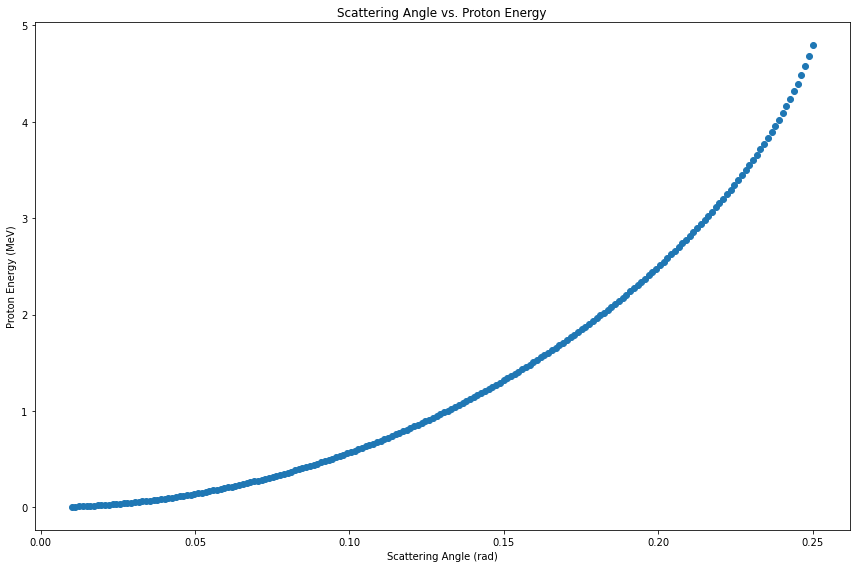

In [ ]:
# let's compute energy transfer for a fixed energy and a bunch of different
# scattering angles
e_i = 14
s_angle_range = np.linspace(0.01, 0.25, 200)
proton_e = [energy_transfer(14, scatter_angle=i)[1] for i in s_angle_range]

plt.scatter(s_angle_range, proton_e)
plt.xlabel("Scattering Angle (rad)")
plt.ylabel("Proton Energy (MeV)")
plt.title("Scattering Angle vs. Proton Energy")
plt.tight_layout()
plt.savefig("pe_v_sa_good.jpg")
plt.show()

In [ ]:
# ok, now let's write a loop to process a lot of particles
# using one on each thread to speed things up
# considering this is a toy model, let's just use one thread for each particle

def run_sim_instance(e_0, stepsize=0.0001, nbins=80, epsilon=0.1, density=0.8562):
    run_data = scatter_sim(e_0, epsilon=epsilon, density=density, stepsize=stepsize)
    return run_data

def sim_wrapper(arg):
    args, kwargs = arg
    return run_sim_instance(*args, **kwargs)

def start_sim(e_0, n_particles, stepsize=0.001, nbins=40, epsilon=0.1, density=0.8562):
    arg = (e_0, )
    kwargs = {'stepsize': stepsize, 'nbins': nbins, 'epsilon': epsilon, 'density': density}
    with Pool(floor((2/3)*cpu_count())) as p:
        sim_data = p.map(sim_wrapper, [(arg, kwargs) for i in range(n_particles)])
        p.close()
        p.join()

    alpha_data = []
    proton_data = []
    for i in sim_data:
        alpha_data.extend(i[0])
        proton_data.extend(i[1])

    return(alpha_data, proton_data)

sim_data = start_sim(14, 200000, nbins=50, stepsize=1E-4)

Process ForkPoolWorker-494:
Process ForkPoolWorker-500:
Process ForkPoolWorker-493:
Process ForkPoolWorker-484:
Process ForkPoolWorker-487:
Process ForkPoolWorker-478:
Process ForkPoolWorker-477:
Process ForkPoolWorker-496:
Process ForkPoolWorker-483:
Process ForkPoolWorker-488:
Process ForkPoolWorker-480:
Process ForkPoolWorker-490:
Process ForkPoolWorker-499:
Process ForkPoolWorker-497:
Process ForkPoolWorker-476:
Process ForkPoolWorker-495:
Process ForkPoolWorker-485:
Process ForkPoolWorker-481:
Process ForkPoolWorker-489:
Process ForkPoolWorker-475:
Process ForkPoolWorker-498:
Process ForkPoolWorker-486:
Process ForkPoolWorker-482:
Process ForkPoolWorker-492:
Process ForkPoolWorker-479:
Process ForkPoolWorker-491:


KeyboardInterrupt: 

In [ ]:
# now to plot the simulation results
#plt.stairs(sim_data.counts, sim_data.bin_edges)
#plt.hist(sim_data.bin_edges[:-1], sim_data.bin_edges, weights=sim_data.counts, rwidth=0.8)
#plt.scatter([(sim_data.bin_edges[i] + sim_data.bin_edges[i-1])/2 for i in
#range(len(sim_data.bin_edges))], sim_data.counts)
#plt.scatter(sim_data.bin_edges[:-1], sim_data.counts)
proton_counts = BinnedCountData(50, d=sim_data[1])
proton_counts.add_count_by_list(sim_data[1])
plt.hist(proton_counts.bin_edges[:-1], proton_counts.bin_edges, weights=proton_counts.counts, rwidth=0.8)
plt.xlabel("Energy")
plt.ylabel("Count")
plt.gca().invert_xaxis()
plt.title("Proton Scattering Event Energy Counts")
plt.show()

ValueError: min() arg is an empty sequence